
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1

In [2]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
    
seaborn.set_context('talk')

url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [3]:
# complete here if you want to include more columns
salary_col = 'salary_monthly_NETO'
lang_col = 'tools_programming_languages'
framework_col = 'tools_frameworks'
relevant_columns = [
    'tools_programming_languages', 
    'salary_monthly_NETO', 
    'salary_monthly_BRUTO',
    'tools_work_pc_os',
    'work_contract_type',
    'tools_frameworks',
    'profile_years_experience',
    'salary_satisfaction',
    'company_main_activity',
    'salary_in_usd',
    'work_role',
    'work_years_in_company',
    'profile_gender',
    'profile_age'
]

In [4]:
# Normalize columns types
df['salary_monthly_NETO'] = df['salary_monthly_NETO'].astype(float)

In [5]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [x.strip().replace(',', '') for x in languages_str.split()]

def remove_outlier(df_in, col_name, iqr_factor = 1.5):
    """
    IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
    accept a dataframe, remove outliers, return cleaned data in a new dataframe
    see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
    """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 # interquartile range
    fence_low  = q1 - iqr_factor*iqr
    fence_high = q3 + iqr_factor*iqr
    df_inliers = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    df_outliers = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    return df_inliers, df_outliers

In [6]:
display(len(df))

df_inliers, df_outliers = remove_outlier(df, 'salary_monthly_NETO', 3.5)

# inliers percent over total
display(len(df_inliers)/len(df))

# display df without outliers
df_inliers['salary_monthly_NETO'].describe()

6095

0.9351927809680065

count      5700.000000
mean      81995.646064
std       46605.212590
min           1.000000
25%       50000.000000
50%       75000.000000
75%      102000.000000
max      290000.000000
Name: salary_monthly_NETO, dtype: float64

In [7]:
# Salario Mínimo en Argentina
# referencia: https://es.wikipedia.org/wiki/Anexo:Salario_m%C3%ADnimo_en_Argentina

min_salary_2021 = float(16875) # de Octubre 2019 a Octubre del 2020 (la encuesta es de Julio/Agosto 2020)

df_outliers_lower_limit = df_inliers.query('salary_monthly_NETO < @min_salary_2021')
df_inliers_lower_limit = df_inliers.query('salary_monthly_NETO >= @min_salary_2021')

df = df_inliers_lower_limit
df['salary_monthly_NETO'].describe()

count      5460.000000
mean      85474.626855
std       44484.198385
min       17000.000000
25%       54000.000000
50%       78000.000000
75%      105000.000000
max      290000.000000
Name: salary_monthly_NETO, dtype: float64

### Curacion de lenguajes de programacion

In [8]:
# Create a new column with the list of languages
df_inliers.loc[:, 'cured_programming_languages'] = df_inliers.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

In [9]:
df_lang = df_inliers.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df_inliers[relevant_columns])\
    .rename(columns={0: 'programming_language'})\
    .reset_index(drop=True)

len(df_lang)

In [40]:
langu = 'go'
role = 'BI Analyst / Data Analyst'
df_lang.query('programming_language == @langu & work_role == @role')

,programming_language,tools_programming_languages,salary_monthly_NETO,salary_monthly_BRUTO,tools_work_pc_os,work_contract_type,tools_frameworks,profile_years_experience,salary_satisfaction,company_main_activity,salary_in_usd,work_role,work_years_in_company,profile_gender,profile_age,cured_programming_languages,role_cat
991,go,"Bash/Shell, CSS, Go, HTML, Javascript, PHP, Py...",122000.0,182000.0,macOS,Full-Time,"Bootstrap, Flask, Laravel, Node.js, Rails, Rea...",15.0,3,Producto basado en Software,NaN,BI Analyst / Data Analyst,5.0,Hombre,36,"[bash/shell, css, go, html, javascript, php, p...",BI / Data Analist


In [10]:
# Filter out languages that we want to exclude
# Complete here with your selected list.
interesting_languages = ["javascript", "sql", "html", "python", "java", "php"\
                         , ".net", "typescript", "c#", "go", "c++", "c", "vba", "kotlin", "swift"]
df_lang = df_lang[df_lang.programming_language.isin(interesting_languages)]
len(df_lang)

13017

## Analisis de roles

### Cuales son los roles para los que hay mas datos?

In [11]:
df_roles_count=df['work_role'].value_counts().reset_index().rename(columns={'index':'work_role', 'work_role':'frequency'})
fig = plt.figure(figsize=(15,15))
seaborn.barplot(data = df_roles_count[df_roles_count['frequency'] > 10], x='frequency', y='work_role')
seaborn.despine()

In [25]:
df_roles_count.sort_values(['frequency'], ascending = False).head(10) 

,work_role,frequency
0,Developer,2140
1,SysAdmin / DevOps / SRE,619
2,Technical Leader,355
3,QA / Tester,232
4,Manager / Director,198
5,HelpDesk,183
6,Project Manager,182
7,Architect,152
8,Consultant,128
9,BI Analyst / Data Analyst,127


### Cuales son los roles que ganan mas?

<AxesSubplot:xlabel='salary_monthly_NETO', ylabel='work_role'>

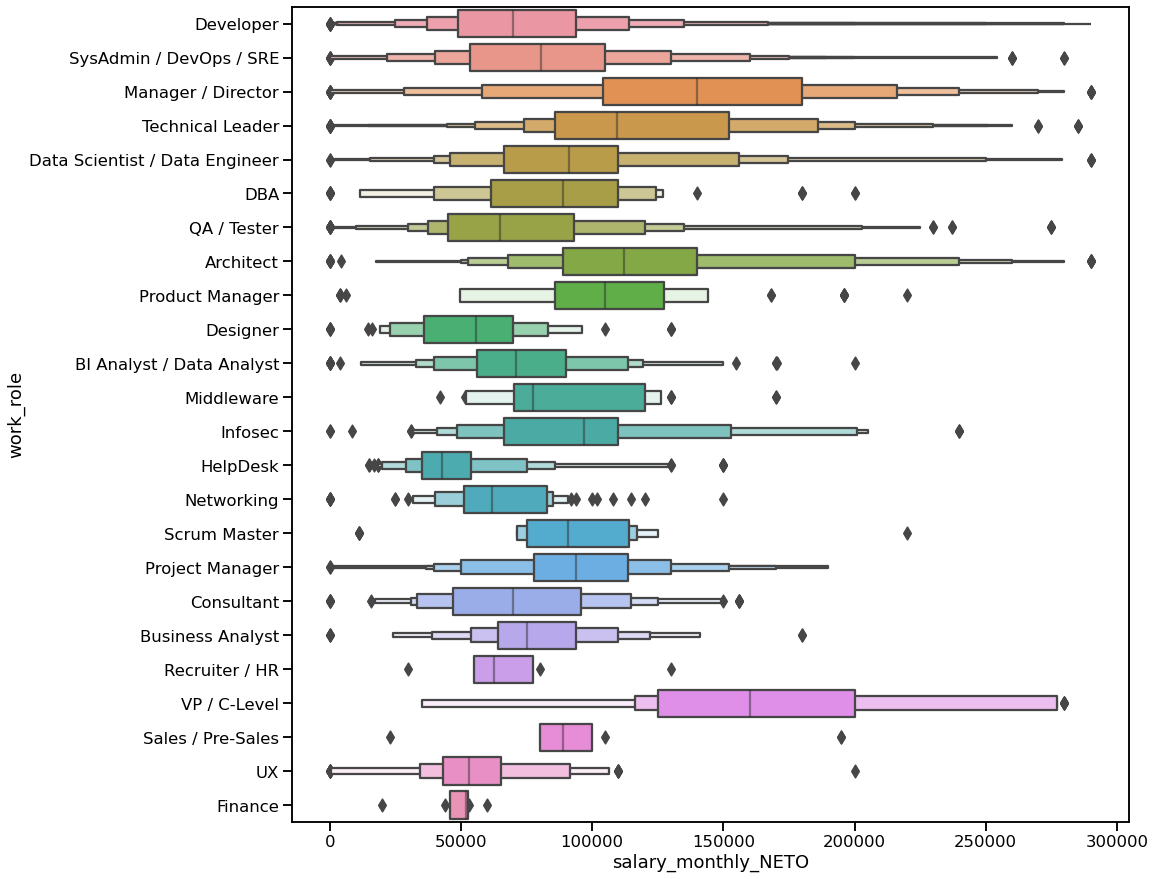

In [12]:
fig = plt.figure(figsize=(15,15))
df_key_roles = df_lang[df_lang["work_role"]\
                          .isin(df_roles_count[df_roles_count["frequency"] > 10]["work_role"])]
seaborn.boxenplot(data = df_key_roles, y='work_role', x='salary_monthly_NETO')

### Como nos interesa visualizar los roles viendolos desde el punto de vista del lenguaje de programacion?

- Los roles mejor pagos
- Los que estan fuertemente relacionados a lenguajes de programacion.

Como calificamos a los roles?

- Roles de desarrollo:
    - Developer
    - SysAdmin / DevOps / SRE
    - QA / Tester
    - Consultant
    - Networking (revisar)
    - Designer
- Roles de liderazgo
    - Manager / Director
    - Architect
    - Project Manager
    - Technical leader
    - Scrum Master
- Roles de Analisis de negocio
    - BI Analyst / Data Analyst + Business Analyst = Business Analist
    - Data Scientist / Data Engineer
- Roles de soporte IT
    - DBA
    - HelpDesk

In [13]:
#seaborn.countplot(y='programming_language', data=df_lang[df_lang['work_role'] == 'Designer'])

# Renombro todos los business analyst a BI Analyst / Data Analyst porque son lo mismo
df_lang.loc[df_lang['work_role'] == "Business Analyst", 'work_role'] = "BI Analyst / Data Analyst"
#len(df_lang[df_lang['work_role'] == "BI Analyst / Data Analyst"])

roles={
    "roles_dev" : [
     #    "Developer",
         "SysAdmin / DevOps / SRE",
         "QA / Tester",
         "Consultant",
         "Networking",
         "Designer"
    ],
    "roles_lead" : [
        "Manager / Director",
        "Architect",
        "Project Manager",
        "Technical leader",
        "Scrum Master"
    ],
    "roles_bi" : [
        "BI Analyst / Data Analyst",
        "Data Scientist / Data Engineer"
    ],
    "roles_it" : [
        "DBA",
        "HelpDesk"
    ]
}

Ahora es la parte donde graficamos los lenguajes relevantes, con un histograma de puntos separado por rol, donde separe los distintos sueldos de cada uno, para cada lenguaje

In [14]:
df_lang['role_cat'] = "no"    

In [15]:
for index, row in df_lang.iterrows():
    if row['work_role'] in roles['roles_dev']:
        df_lang.at[index,'role_cat'] =  "Developer"
    elif row['work_role'] in roles['roles_lead']:
        df_lang.at[index,'role_cat'] =   "Leadership"
    elif row['work_role'] in roles['roles_bi']:
        df_lang.at[index,'role_cat'] =   "BI / Data Analist"
    elif row['work_role'] in roles['roles_it']:
        df_lang.at[index,'role_cat'] =   "IT"
    else: row['role_cat'] = "none"

## Ejercicio 1 - Analisis Descriptivo

In [16]:
df_lang[df_lang["programming_language"] == "python"]["work_role"]

3                      Developer
12       SysAdmin / DevOps / SRE
31       SysAdmin / DevOps / SRE
35                     Developer
37                     Developer
                  ...           
16681                  Developer
16686    SysAdmin / DevOps / SRE
16688                 Networking
16691    SysAdmin / DevOps / SRE
16708    SysAdmin / DevOps / SRE
Name: work_role, Length: 1358, dtype: object

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


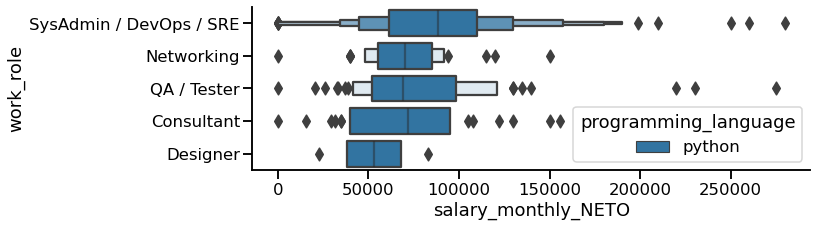

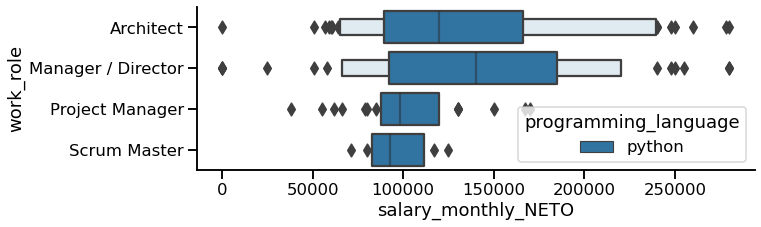

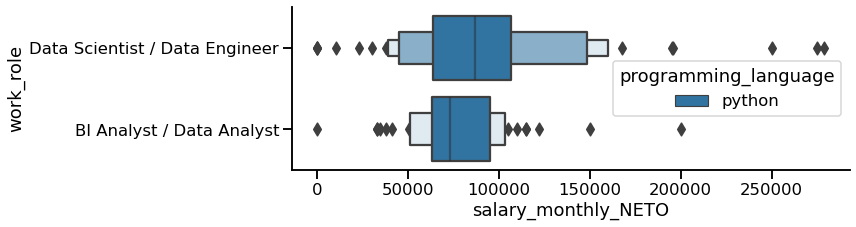

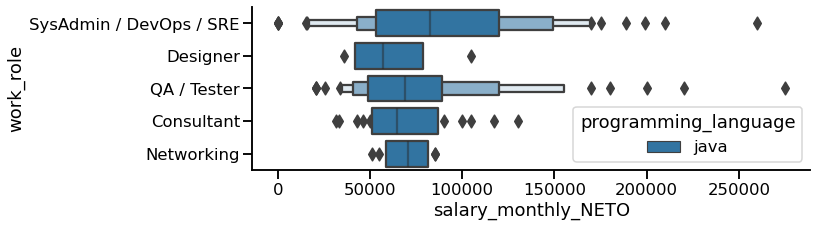

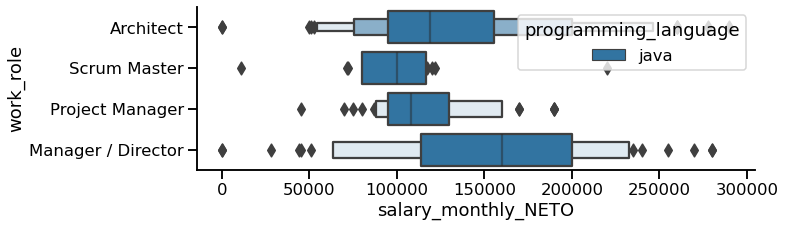

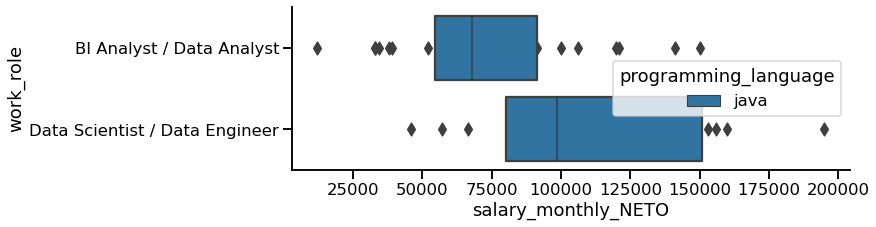

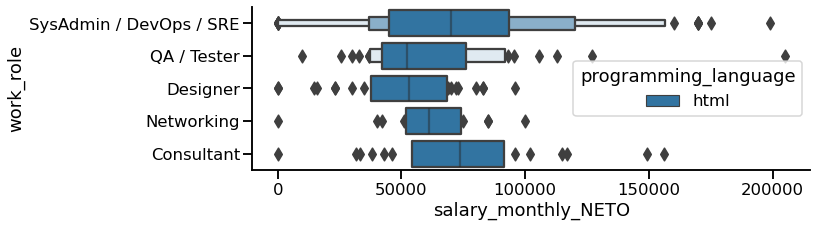

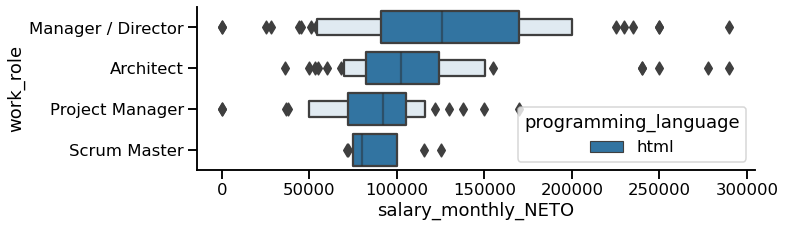

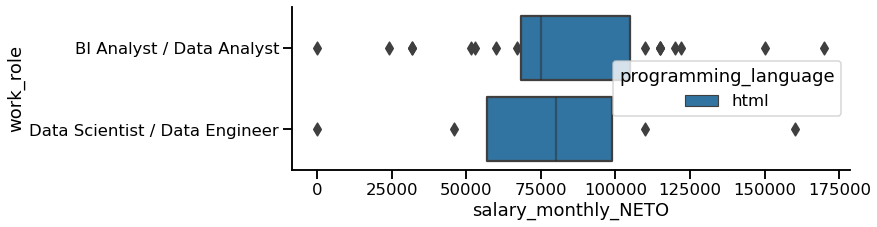

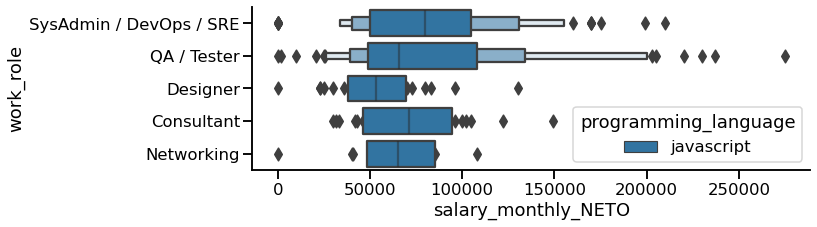

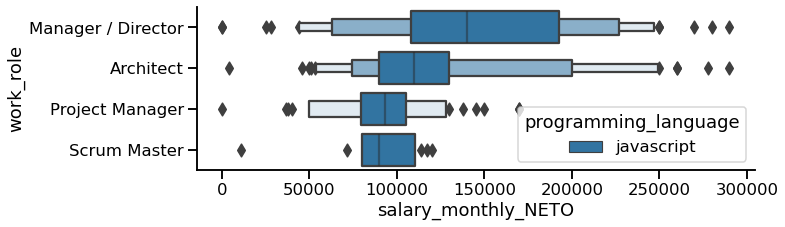

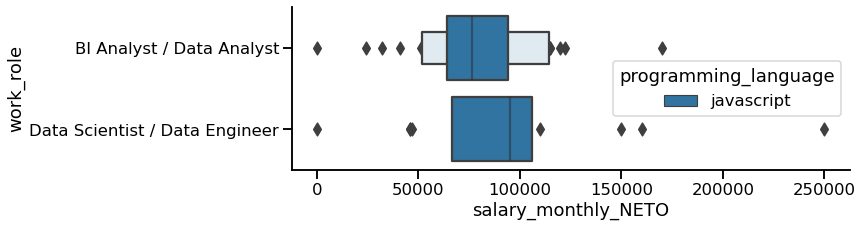

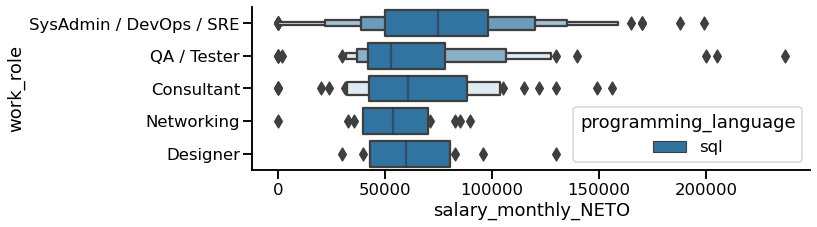

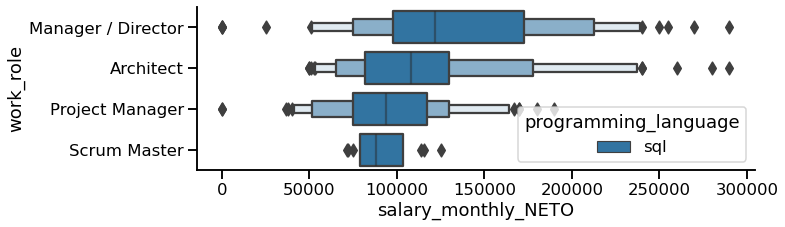

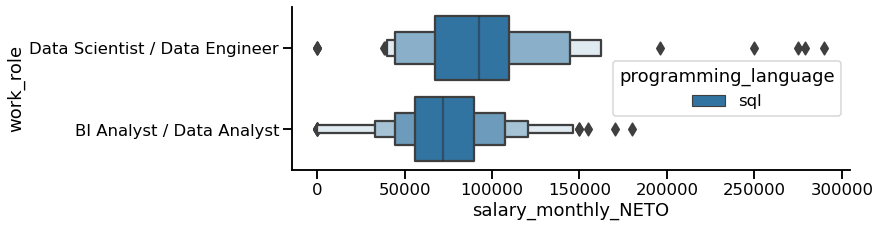

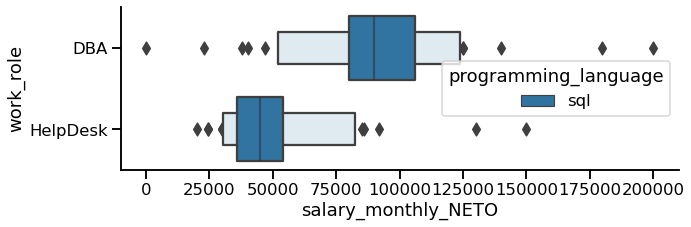

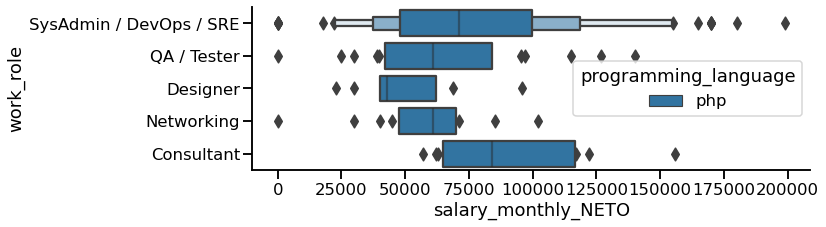

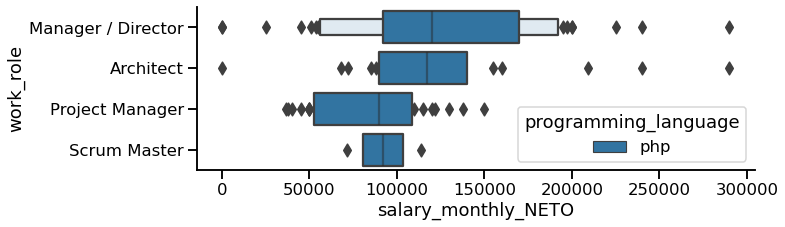

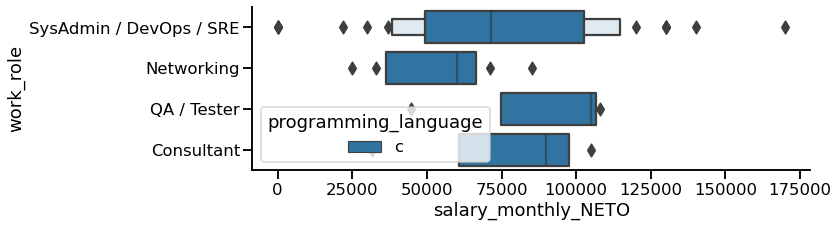

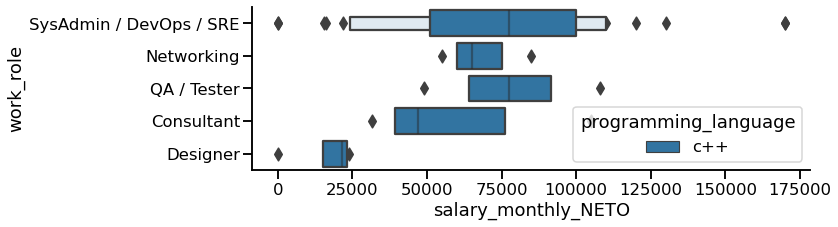

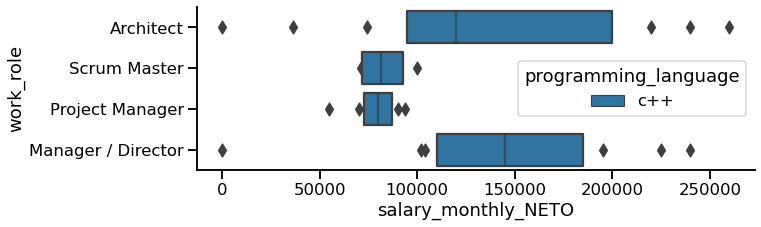

In [17]:
programming_languages = ['python', 'java', 'html', 'javascript', 'sql', 'php', 'c', 'c++', 'swift']
#fig, axes = plt.subplots(nrows=len(programming_languages), figsize=(16, 10))

for lang in programming_languages:
    for role in roles:
        df_lang_x = df_lang[df_lang["programming_language"] == lang]
#        print("role:", role)
 #       print("lang:", lang)
  #      print (len(df_lang_x[df_lang_x["work_role"].isin(roles[role])]))
        if len(df_lang_x[df_lang_x["work_role"].isin(roles[role])]) > 30:
            fig, axes = plt.subplots(nrows=1, figsize=(10, 3))
            g = seaborn.boxenplot(
                data=df_lang_x[df_lang_x["work_role"].isin(roles[role])], 
                x='salary_monthly_NETO',
                y='work_role',
                hue="programming_language"
            )
            plt.ticklabel_format(style='plain', axis='x')
            seaborn.despine()

## Cantidad de casos para cada lenguaje relevante, separado por roles
Determina la significancia de los graficos que surgen a partir de estos datos

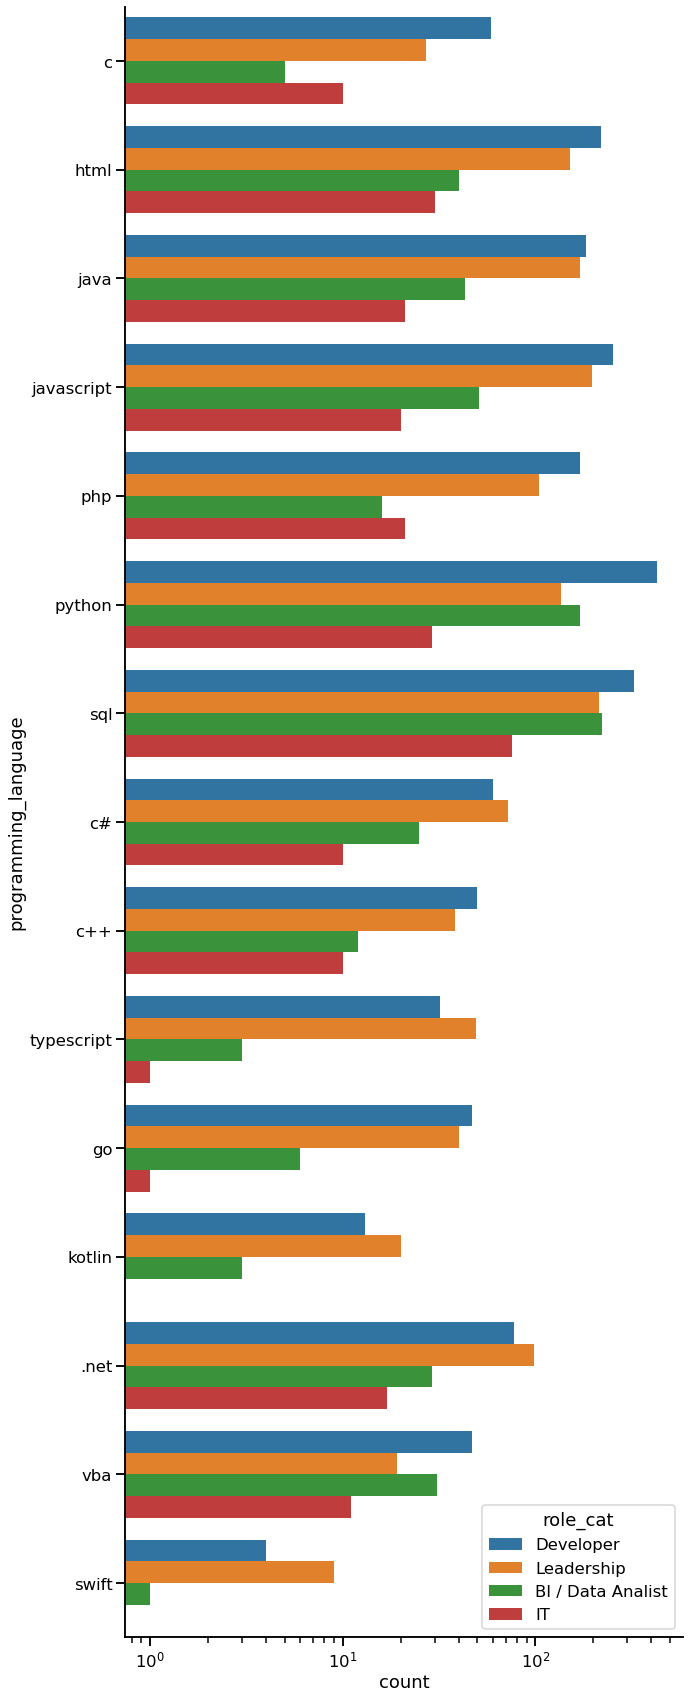

In [18]:
fig, axes = plt.subplots(nrows=1, figsize=(10, 30))
g = seaborn.countplot(
    data=df_lang[df_lang['role_cat'] != 'no'], 
    #x=df_lang['salary_monthly_NETO'],
    hue='role_cat',
    y="programming_language"
)
plt.ticklabel_format(style='plain', axis='x')
g.set_xscale('log')
seaborn.despine()

## Distribucion de sueldos para lenguajes relevantes segun roles

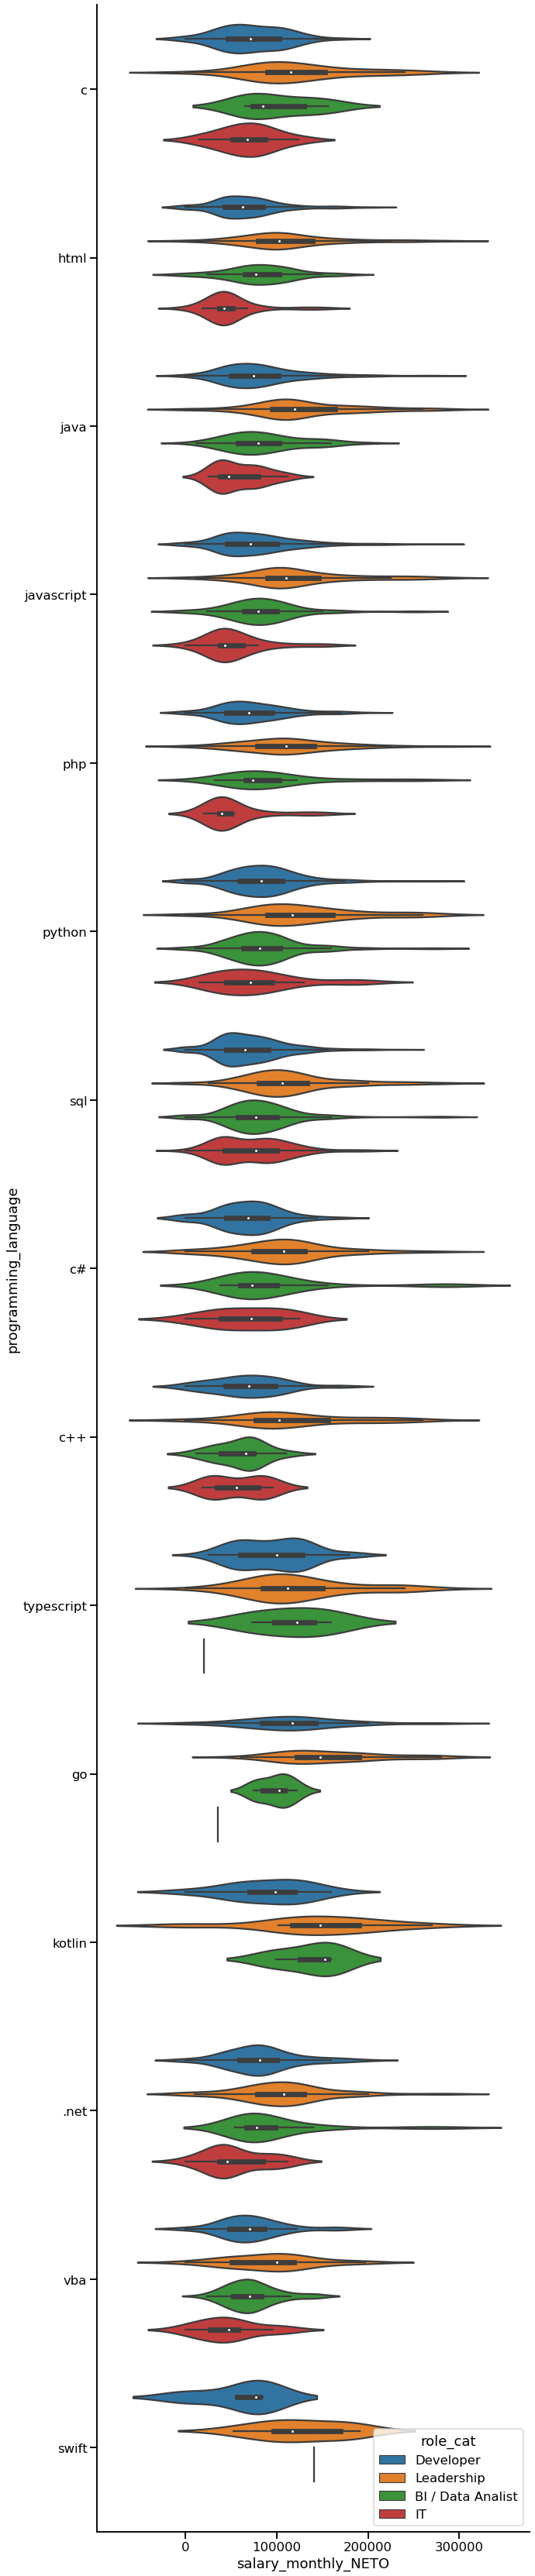

In [19]:
#df_lang_x = df_lang[df_lang["programming_language"] == lang]
#        print("role:", role)
#       print("lang:", lang)
#      print (len(df_lang_x[df_lang_x["work_role"].isin(roles[role])]))
fig, axes = plt.subplots(nrows=1, figsize=(10, 60))
g = seaborn.violinplot(
    data=df_lang[df_lang['role_cat'] != 'no'], 
    x='salary_monthly_NETO',
    hue='role_cat',
    y="programming_language"
)
plt.ticklabel_format(style='plain', axis='x')
seaborn.despine()

In [20]:
df_lang[df_lang["work_role"] == 'Networking']

,programming_language,tools_programming_languages,salary_monthly_NETO,salary_monthly_BRUTO,tools_work_pc_os,work_contract_type,tools_frameworks,profile_years_experience,salary_satisfaction,company_main_activity,salary_in_usd,work_role,work_years_in_company,profile_gender,profile_age,cured_programming_languages,role_cat
268,c++,"C++, Perl, Python",65000.0,73000.0,Windows,Full-Time,Spark,12.0,3,Servicios / Consultoría de Software / Digital,NaN,Networking,12.0,Hombre,35,"[c++, perl, python]",Developer
270,python,"C++, Perl, Python",65000.0,73000.0,Windows,Full-Time,Spark,12.0,3,Servicios / Consultoría de Software / Digital,NaN,Networking,12.0,Hombre,35,"[c++, perl, python]",Developer
354,python,Python,70000.0,90000.0,Windows,Full-Time,SAP,22.0,1,Otras industrias,NaN,Networking,5.0,Hombre,47,[python],Developer
685,html,"Bash/Shell, HTML, Python, SQL",54000.0,66214.0,Windows,Full-Time,WordPress,20.0,2,Otras industrias,NaN,Networking,9.0,Hombre,45,"[bash/shell, html, python, sql]",Developer
686,python,"Bash/Shell, HTML, Python, SQL",54000.0,66214.0,Windows,Full-Time,WordPress,20.0,2,Otras industrias,NaN,Networking,9.0,Hombre,45,"[bash/shell, html, python, sql]",Developer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16673,javascript,"Bash/Shell, CSS, HTML, Java, Javascript, PHP, ...",70000.0,90000.0,Windows,Full-Time,"Bootstrap, jQuery, Yii2",11.0,3,Otras industrias,NaN,Networking,7.0,Hombre,31,"[bash/shell, css, html, java, javascript, php,...",Developer
16674,php,"Bash/Shell, CSS, HTML, Java, Javascript, PHP, ...",70000.0,90000.0,Windows,Full-Time,"Bootstrap, jQuery, Yii2",11.0,3,Otras industrias,NaN,Networking,7.0,Hombre,31,"[bash/shell, css, html, java, javascript, php,...",Developer
16675,python,"Bash/Shell, CSS, HTML, Java, Javascript, PHP, ...",70000.0,90000.0,Windows,Full-Time,"Bootstrap, jQuery, Yii2",11.0,3,Otras industrias,NaN,Networking,7.0,Hombre,31,"[bash/shell, css, html, java, javascript, php,...",Developer
16676,sql,"Bash/Shell, CSS, HTML, Java, Javascript, PHP, ...",70000.0,90000.0,Windows,Full-Time,"Bootstrap, jQuery, Yii2",11.0,3,Otras industrias,NaN,Networking,7.0,Hombre,31,"[bash/shell, css, html, java, javascript, php,...",Developer


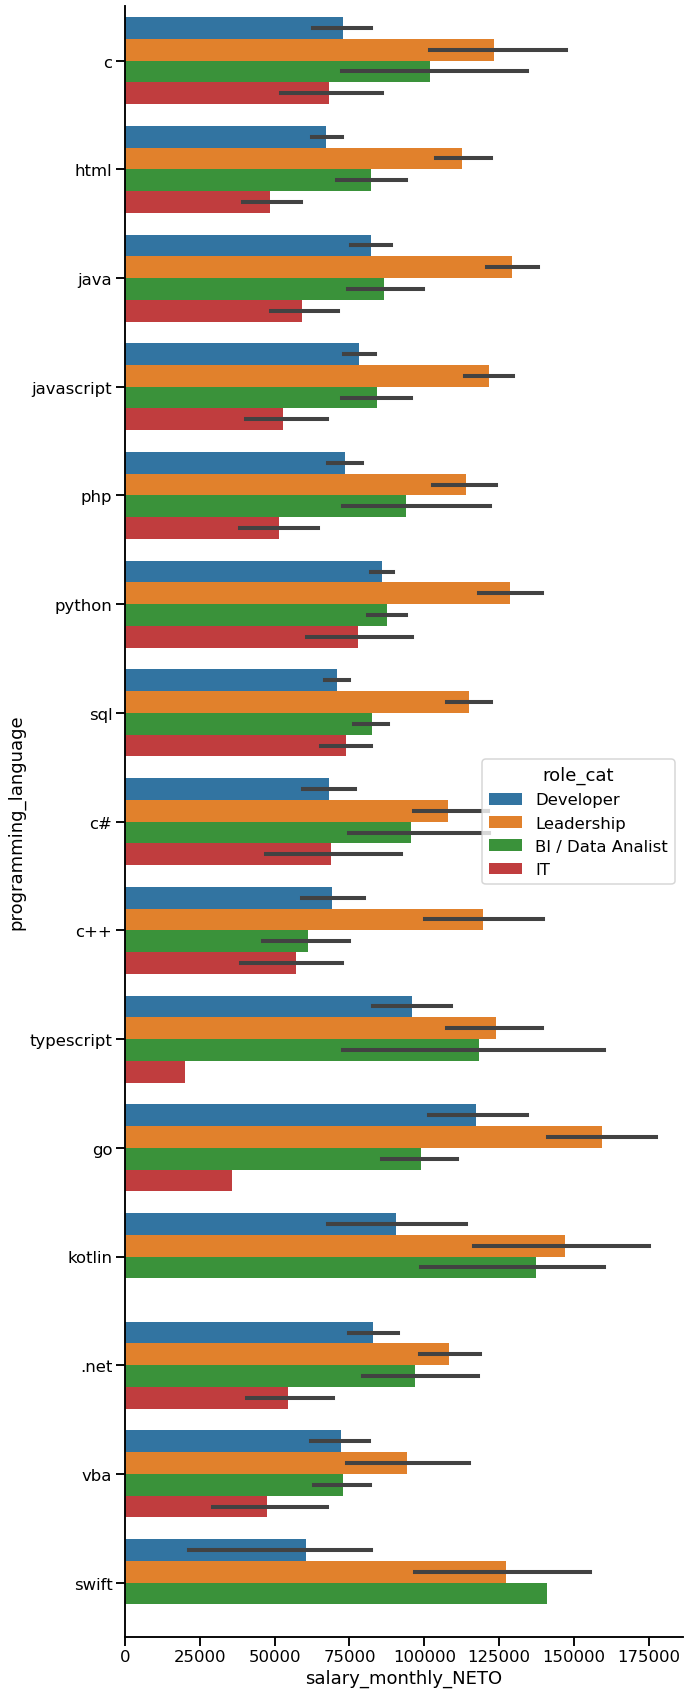

In [21]:
fig, axes = plt.subplots(nrows=1, figsize=(10, 30))
g = seaborn.barplot(
    data=df_lang[df_lang['role_cat'] != 'no'], 
    x=df_lang['salary_monthly_NETO'],
    hue='role_cat',
    y="programming_language"
)
plt.ticklabel_format(style='plain', axis='x')
seaborn.despine()

### Observaciones

El dataset no proporciona informacion suficiente para representar correctamente los salarios para todos los lenguajes en los roles asignados. Sin embargo, en los lenguajes mas populares es posible observar ciertas caracteristicas comunes:

- Los salarios mas altos estan en los roles de liderazgo
- Los salarios mas bajos estan en los roles de soporte
- Los salarios de desarrollo y de BI / Data Analyst compiten en distintos lenguajes, con tendencia a ser mayor en roles de BI / Data Analyst.

In [22]:
language_count = filtered_df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})

NameError: name 'filtered_df_lang' is not defined

In [ ]:
fig = plt.figure(figsize=(15,15))
seaborn.barplot(data = language_count[language_count['frequency'] > 11], x='frequency', y='language')
seaborn.despine()

In [ ]:

filtered_df_lang
    
#df.loc[:, ['tools_programming_languages','work_role']]


#### _Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante_

Asociar el lenguaje de programacion al rol que se declara cada uno nos puede ayudar a brindar detalle sobre el tipo de trabajo que se realiza en cada puesto. De esta manera no solamente podemos inferir sobre el salario de los que trabajan en python, sino ademas de los que usan python para distintos propositos, como puede ser, por ejemplo, desarrollo web, o data science. 

In [ ]:
language_count[language_count['frequency'] > 11]

In [ ]:
fig = plt.figure(figsize=(15, 20))
g = seaborn.violinplot(
    data=clean_outliers(filtered_df_lang, "salary_monthly_NETO"), 
    x='salary_monthly_NETO',
    y='programming_language', 
)
plt.ticklabel_format(style='plain', axis='x')
seaborn.despine()

In [ ]:
len(df_lang[df_lang["programming_language"].isin(language_count[language_count["frequency"] > 10]["language"])])

In [ ]:
len(df_lang)

In [ ]:
df[df["tools_programming_languages"] == 'ninguno']

# Ejercicio 2 - Densidades y varias varialbes

Responder a la pregunta general: **¿Que herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?**

Para ello considere (igual al ejercicio Anterior):
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en sub-poblaciones. 

In [ ]:
df.columns

Analizando las columnas se puede extraer un subgrupo que se pueda considerar como las columnas que mejor describan al estudio. Se trata de un estudio de empleos en programacion. Esta orientado al tipo de vida de una persona relacionado con su empleo. Ademas, se incluyen las columnas donde se puede inferir que se puede obtener informacion que pueda llegar a despertar interes general. 

In [ ]:
relevant_columns = [
    "profile_gender",
    "profile_age",
    "work_province", # solo provincia porque se sabe que el estudio es en argentina
    "profile_years_experience",
    "profile_studies_level",
    "profile_career",
    "work_role",
    "tools_programming_languages",
    "salary_monthly_NETO",
    "work_has_violence_situations",
    "profile_has_disabilities",
    "company_main_activity",
    "company_diversity_policies"
]

## a) Densidad conjunta

Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa




## b) Asociación

* Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría



## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación






## d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)